<h2>SMS Spam Filter</h2>

We will build a basic spam filter using the UCI SMS Spam Collection Data Set: https://archive.ics.uci.edu/ml/datasets/sms+spam+collection


In [67]:
import numpy as np
import string
import pandas as pd
import matplotlib.pyplot as plt
import re
from collections import Counter
from sklearn.model_selection import train_test_split
%matplotlib inline

In [68]:
import warnings
warnings.filterwarnings('ignore')

We begin by reading in the data and only keeping columns that indicate spam/ham and content of message.

In [557]:
df = pd.read_csv('spam.csv',encoding='latin-1')

df = df[['v1','v2']]

df.columns = ['Spam','Message']

In [558]:
df.head()

,Spam,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Check for any disparity between amount of spam and ham messages.

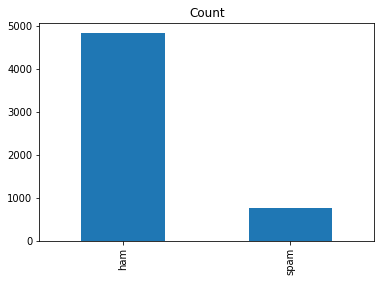

In [559]:
df.Spam.value_counts().plot(kind='bar', title='Count')
plt.show()

Ham messages far exceed spam messages in this data set.

Convert spam/ham column to 0='ham' and 1='spam'.

In [560]:
# check which rows are spam to get TRUE/FALSE then multiply Spam column by 1
df['Spam'] = df.Spam.eq('spam').mul(1)

In [561]:
df.head()

,Spam,Message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


Separate into train and test set with 25% of data going to test and utilize stratify to ensure the same proportion of spam in each set.

In [562]:
train_set, test_set = train_test_split(df,test_size=0.25,stratify=df['Spam'],random_state=42)

Check ratio of spam in both train and test set. Want the values to be close. 

In [563]:
train_SpamRatio = round(sum(train_set['Spam'])/len(train_set)*100,2)
test_SpamRatio = round(sum(test_set['Spam'])/len(test_set)*100,2)
print('train spam: %.2f%%  \ntest spam: %.2f%% ' %(train_SpamRatio,test_SpamRatio))

train spam: 13.40%  
test spam: 13.42% 


The values are close enough so we may proceed.

We will define the function messageList to transform each message into a list of strings and remove nonchar elements as well as converting to lowercase.

In [89]:
def messageList(s):
    # split strings and convert to lowercase
    s = re.findall(r"[\w']+|[.,!?;]", s.lower())
    # remove punctuations and digits
    s = [x.translate(str.maketrans('', '', string.punctuation)) for x in s ]
    l = [x for x in s if not any(c.isdigit() for c in x)]
    final = [x for x in l if x.isalnum()]
    return(final)

Separate ham and spam observations into their own dataframes to gain further insights into each group individually.

In [564]:
ham = train_set.loc[(train_set['Spam']==0)]
spam = train_set.loc[(train_set['Spam']==1)]

Apply messageList function to both dataframes.

In [565]:
ham.loc[:,'messageList'] = pd.Series(ham['Message'].apply(messageList))
spam.loc[:,'messageList'] = pd.Series(spam['Message'].apply(messageList))

Build ham and spam word libraries.

In [566]:
# isolate all words in ham messages
hamLib = ham.messageList.tolist()
hamLib = list([a for b in hamLib for a in b])

# isolate all words in spam messages
spamLib = spam.messageList.tolist()
spamLib = list([a for b in spamLib for a in b])

# build separate list of all ham and spam words
# Note one could input an integer n to the most_common function
# in order to return only the top n words in each category. 
hamLib_Common = [word for word, word_count in Counter(hamLib).most_common()]
spamLib_Common = [word for word, word_count in Counter(spamLib).most_common()]

Want to remove words that show up in both ham and spam libraries.

In [567]:
# Define function to return words that are common to both ham and spam libraries.
def intersection(l1, l2): 
    temp = set(l2) 
    l3 = [val for val in l1 if val in temp] 
    return(l3)

In [568]:
# define library of intersecting words between ham and spam
interLib = intersection(hamLib_Common,spamLib_Common)

In [569]:
# remove intersecting words from the ham and spam libraries
hamLib2 = list(set(hamLib_Common)^set(interLib))
spamLib2 = list(set(spamLib_Common)^set(interLib))

Form totalLib using the unique ham and unique spam words.

In [570]:
totalLib = hamLib2 + spamLib2

In [571]:
# Apply messageList function to trainining set
train_set.loc[:,'messageList'] = pd.Series(train_set['Message'].apply(messageList))

Find length of SMS.

In [572]:
def messageLength(messList):
    return(len(messList))

In [573]:
train_set['messageLen'] = train_set['messageList'].apply(messageLength)

As most Spam messages contain numbers and multiple capital letters, we will add a feature to calculate this.

In [574]:
def howManyCapsInts(messList):
    caps = sum(1 for c in messList if c.isupper())
    ints = sum(c.isdigit() for c in messList)
    return(caps+ints)

In [575]:
train_set['caps&ints'] = train_set['Message'].apply(howManyCapsInts)

Also we will add a feature that shows the ratio of nonalphanumeric characters to the length of the message.

In [576]:
#function to figure out the ratio of non alphanumeric characters to length of string
def non_alphaNum(s):
    length = len(s)
    pattern = r'[^a-zA-Z0-9\_\s]'
    result = re.findall(pattern, s)
    return(len(result)/length)

In [577]:
train_set['ratio'] = train_set['Message'].apply(non_alphaNum)

Obtain words in each message that fall into the totalLib library. We will apply bag of words to this list later.

In [578]:
# return list of words in each original message that also fall in totalLib constructed above
def topMessage(m):
    uniqueM = set(m)
    res = [x for x in totalLib if x in m]
    return(res)

In [579]:
train_set.loc[:,'cleanMessage'] = pd.Series(train_set['messageList'].apply(topMessage))

In [580]:
# define bag of words function to vectorize each SMS
def bow(m,vocab):
    bag = np.zeros(len(vocab))
    for word in m:
        for i,j in enumerate(vocab):
            if j==word:
                bag[i]+=1
                
    return(np.array(bag))

Build new dataframe of vectorized messages with totalLib word library as features and merge with message length,# of capital and digits, and proportion of nonalphanumeric to form full training set.

In [581]:
vec =  pd.DataFrame()

vec['col'] = (np.array(train_set.apply(lambda row : bow(row['cleanMessage'], 
                                 totalLib), axis = 1)))

vec =  vec.col.apply(pd.Series)

Now we will apply term frequency-inverse document frequency (tf-idf). The key idea is to weigh words like 'the','that','is' less as these terms likely appear frequently in the messages. More weight is added to words that appear several times in a single SMS but do not appear much in the rest of the collection of messages. Generally applying tf-idf performs better than raw word counts.

In [582]:
def tf_idf(freq):
    # divide each entry by its row sum then multiply by log (#rows/column sum)
    size = len(freq)
    tf = freq.div(freq.sum(axis=1)+.1, axis=0)
    idf = np.log(size/freq.sum())
    tfidf = tf*idf
    return([tfidf,idf])

In [607]:
# save idf value to apply it to test set later on
vec,idf = tf_idf(vec)

In [584]:
trainX = train_set[['messageLen','caps&ints','ratio']]

In [585]:
trainX = trainX.reset_index().drop('index',axis=1)

In [586]:
trainX = pd.concat([trainX, vec], axis=1, sort=False)
trainY = train_set['Spam']

We will now attempt different algorithms in search of one that offers strong performance on precision. As this is a spam filter, the biggest concern would be a user missing an SMS that should not have been classified as spam.

In [587]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB,GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

In [588]:
# model =  SVC(C=10,class_weight='balanced',gamma='auto',kernel='rbf')
model = RandomForestClassifier(n_estimators=100,max_features= 'log2',
                               class_weight='balanced',random_state=42,max_depth=50) 
# model = MultinomialNB(fit_prior=True)
scores = cross_val_score(model,trainX,trainY,scoring='precision',cv=5)

In [589]:
print('Median precision:' ,round(np.median(scores),5))

Median precision: 0.99057


GridSearch or RandomizedSearch can be utilized to fine tune whichever model was chosen by user. Sample code for RandomizedSearchCV is shown below.

In [591]:
# from sklearn.model_selection import RandomizedSearchCV

# param_grid = {'n_estimators': [100,200,300], 'max_features': ['auto',None],'class_weight': 
#     ['balanced','balanced_subsample',None],'max_depth':[10,20]}


# model = RandomForestClassifier()

# random_search = RandomizedSearchCV(model,param_distributions=param_grid,cv=5,scoring='f1')

## Prepare test set.

In [592]:
testY = test_set['Spam']
test_set2 = test_set.drop(['Spam'],axis=1)
test_set2.loc[:,'messageList'] = pd.Series(test_set2['Message'].apply(messageList))
test_set2['messageLen'] = test_set2['messageList'].apply(messageLength)
test_set2['caps&ints'] = test_set2['Message'].apply(howManyCapsInts)
test_set2['ratio'] = test_set2['Message'].apply(non_alphaNum)
test_set2.loc[:,'cleanMessage'] = pd.Series(test_set2['messageList'].apply(topMessage))

In [593]:
test_vec =  pd.DataFrame()
test_vec['col'] = (np.array(test_set2.apply(lambda row : bow(row['cleanMessage'], 
                                 totalLib), axis = 1)))
test_vec =  test_vec.col.apply(pd.Series)

In [594]:
test_tf = test_vec.div(test_vec.sum(axis=1)+.1, axis=0)
test_vec = test_tf * idf

In [595]:
testX =  test_set2[['messageLen','caps&ints','ratio']]
testX = testX.reset_index().drop('index',axis=1)
testX = pd.concat([testX,test_vec],axis=1,sort=False)

<h2>Fit model and make predictions.</h2>

In [596]:
model.fit(trainX,trainY)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=50, max_features='log2',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)

In [597]:
feat_imp = model.feature_importances_
np.argsort(feat_imp)[-3:]

array([   0, 5259,    1])

2 of the top 3 important features were message length and # of captial and integers.

In [598]:
results = model.predict(testX)

In [599]:
print(classification_report(testY, results))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1206
           1       1.00      0.86      0.93       187

    accuracy                           0.98      1393
   macro avg       0.99      0.93      0.96      1393
weighted avg       0.98      0.98      0.98      1393



In [600]:
auc = roc_auc_score(testY, results, average='macro')
print('Area under ROC:',round(auc,2))

Area under ROC: 0.93


Scores all around are good but most importantly the probability of an SMS actually being spam given a prediciton of spam, is at 100%. Recall dips below .9 but we can live with a few spam messages getting through.

Summarize with confusion matrix.

In [601]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(testY, results)

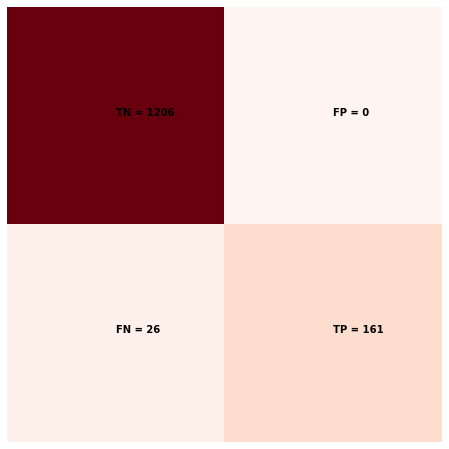

In [602]:
plt.figure(figsize=(8,8)) 
plt.imshow(conf_mat, cmap='Reds')
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(conf_mat[i][j]),weight='bold')
plt.axis('off')
plt.show()

Trial message

In [603]:
def transform(message):
    m = messageList(message)
    length = messageLength(m)
    num_caps = howManyCapsInts(message)
    rat = non_alphaNum(message)
    clean = topMessage(m)
    bag = bow(clean,totalLib)
    bag = bag/(sum(bag)+.1)
    bag = bag*idf
    feat = np.array([length,num_caps,rat])
    final = np.concatenate((feat,bag))
    return(final)
    

In [648]:
# a spam message I get often
s = ('URGENT! Your WF account is locked.'
    'Please log in at http:// to secure your account now.')


In [649]:
trial = transform(s)

In [650]:
if model.predict(trial.reshape(1,-1))[0] ==0:
    print('Not spam')
else:
    print('Spam')

Spam
